# Experiment no.13 \[pilot\]

# 1. Imports

In [1]:
# torch family
import torch
from torch.utils.data import DataLoader, Subset, random_split

# torchvision family
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import functional as F
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2 # G. model
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_320_fpn # L. model
from torchvision.ops import nms

# COCO family
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# utilities
import os
import sys
import numpy as np
import matplotlib.pyplot as plt # Visualization
from PIL import Image, ImageDraw # Visualization
import json # Result management

# Stochastic noise
sys.path.append('/home/hwkang/jupyter/root/')
sys.path.append('/home/hwkang/jupyter/root/utility/detection')
from utility.synthesize import generate_one_noisy_image
from utility.detection import utils, engine

# 2. Constants

In [2]:
# Paths
path_root_coco = '/home/hwkang/jupyter/root/dataset/COCO2017/'
path_train = os.path.join(path_root_coco, 'train2017')
path_valid = os.path.join(path_root_coco, 'val2017')
path_ann = os.path.join(path_root_coco, 'annotations')
path_file_ann_train = os.path.join(path_ann, 'instances_train2017.json')
path_file_ann_valid = os.path.join(path_ann, 'instances_val2017.json')

# 3. Data

## 3.1. Dataset

### 3.1.1. Custom dataset declaration

In [3]:
class CustomCocoDetection(torch.utils.data.Dataset):
    def __init__(self, image_dir, ann_file, transform=None):
        self.root = image_dir
        self.transform = transform
        self.coco = COCO(ann_file)
        self.ids = list(self.coco.imgs.keys())

    def __getitem__(self, index):
        img_id = self.ids[index]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        path = self.coco.loadImgs(img_id)[0]['file_name']

        img = Image.open(os.path.join(self.root, path)).convert('RGB')

        image_id = torch.tensor([img_id])
        labels = [] # category_id 
        boxes = []

        for ann in anns:
            bbox = torch.tensor(ann['bbox'], dtype=torch.float32)
            bbox[2:4] += bbox[0:2] # Convert format XYWH to XYXY

            # If W and H are lesser equal than X_min and Y_min, then add tiny value
            # 만약 W와 H가 offset(x,y)보다 작거나 같다면, 이 bbox 라벨에 아주 작은 값을 추가
            if( bbox[0] >= bbox[2] or bbox[1] >= bbox[3] ):
                if( bbox[0] >= bbox[2] ):
                    bbox[2] += 0.1
                if( bbox[1] >= bbox[3] ):
                    bbox[3] += 0.1
            
            labels.append(ann['category_id'])
            boxes.append(bbox)

        # If it is not a background image which label is zero('0')
        # 배경(background) 이미지가 아닌 경우
        if len(boxes) > 0:
            labels = torch.as_tensor(labels, dtype=torch.int64)
            boxes = torch.stack(boxes)
        
        # Otherwise, that is background image
        # 배경 이미지인 경우
        else:
            labels = torch.zeros((0,), dtype=torch.int64)
            boxes = torch.zeros((0, 4), dtype=torch.float32)

        if self.transform is not None:
            img = self.transform(img)

        # image_id: metadata
        # labels: training, evaluation 
        # boxes: training, evaluation
        # area: 'not in use' (LASTEST Upd.: 24-08-09 16:23)
        # iscrowd: 'not in use' (LATEST Upd.: 24-08-09 16:23)
        target = {
            'image_id': image_id,
            'labels': labels,
            'boxes': boxes
                 }

        return img, target

    def __len__(self):
        return len(self.ids)

In [4]:
class PredictedLabelDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, ann_file, results, transform=None, noise=False):
        self.root = image_dir
        self.coco = COCO(ann_file)
        """
        results contains ...
        [image_id]: int
        [category_id]: int
        [bbox]: float
        [score]: float
        """
        self.results = results
        self.ids = list({item['image_id'] for item in results}) # results에 있는 모든 image_id 리스트
        self.transform = transform
        self.noise = noise

    def __getitem__(self, index):
        img_id = self.ids[index]

        # 실제 이미지 로딩
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        path = self.coco.loadImgs(img_id)[0]['file_name']
        img = Image.open(os.path.join(self.root, path)).convert('RGB')

        image_id = torch.tensor([img_id])
        labels = [] # category_id 
        boxes = []
        areas = []
        iscrowds = []

        filtered_dicts = [d for d in self.results if d.get('image_id') == img_id]

        for d in filtered_dicts:
            bbox = torch.tensor(d['bbox'], dtype=torch.float32)
            bbox[2:4] += bbox[0:2] # Convert XYWH to XYXY

            if( bbox[0] >= bbox[2] or bbox[1] >= bbox[3] ):
                if( bbox[0] >= bbox[2] ):
                    bbox[2] += 0.1
                if( bbox[1] >= bbox[3] ):
                    bbox[3] += 0.1
                    
            labels.append(d['category_id'])
            boxes.append(bbox)

        # If it is not a background image which label is zero('0')
        # 배경(background) 이미지가 아닌 경우
        if len(boxes) > 0:
            labels = torch.as_tensor(labels, dtype=torch.int64)
            boxes = torch.stack(boxes)
        
        # Otherwise, that is background image
        # 배경 이미지인 경우
        else:
            labels = torch.zeros((0,), dtype=torch.int64)
            boxes = torch.zeros((0, 4), dtype=torch.float32)

        if self.transform is not None:
            img = self.transform(img)

        if self.noise:
            img = generate_one_noisy_image(img, intensity=0.5, noise_type='gaussian')

        # image_id: metadata
        # labels: training, evaluation 
        # boxes: training, evaluation
        # area: 'not in use' (LASTEST Upd.: 24-08-09 16:23)
        # iscrowd: 'not in use' (LATEST Upd.: 24-08-09 16:23)
        target = {
            'image_id': image_id,
            'labels': labels,
            'boxes': boxes,
                 }

        return img, target

    def __len__(self):
        return len(self.ids)

In [5]:
transform = transforms.Compose([
    transforms.ToTensor()
])

### 3.1.2. Dataset instances

In [6]:
# Training
train_dataset = CustomCocoDetection(path_train, path_file_ann_train, transform)

# Resized training dataset
train_dataset = Subset(train_dataset, list(range(10000)))

loading annotations into memory...
Done (t=10.70s)
creating index...
index created!


In [7]:
# Split training dataset w. ratio '8:2'
# 실제 훈련 데이터 9, 검증용 데이터 1로 기존 훈련용 데이터 분할
dataset_size = len(train_dataset)
train_size = int(0.8 * dataset_size)
valid_size = dataset_size - train_size

# Split Training
# Split Validation
split_train_dataset, split_valid_dataset = random_split(train_dataset, [train_size, valid_size])

In [8]:
# Sample datasets '80%' to '10%' x 8 
# Divide 'Split Training' to 'Sample Training'
total_length = len(split_train_dataset)
base_length = total_length // 8
split_lengths = [base_length] * 8

for i in range(total_length % 8):
    split_lengths[i] += 1

sample_datasets = random_split(split_train_dataset, split_lengths)

In [9]:
# Test
# NOTE: 원래는 검증용 데이터로 사용되어야 하나, 테스트 데이터가 없어 이 데이터셋을 테스트용으로 사용
test_dataset = CustomCocoDetection(path_valid, path_file_ann_valid, transform)

loading annotations into memory...
Done (t=1.41s)
creating index...
index created!


## 3.2. DataLoader

In [10]:
# Create DataLoader instances

# Split Validation
split_valid_loader = DataLoader(split_valid_dataset, batch_size=8, shuffle=False, collate_fn=utils.collate_fn) # Not in use

In [11]:
# Sample training
sample_loaders = [DataLoader(sample_dataset, batch_size=8, shuffle=True, collate_fn=utils.collate_fn) for sample_dataset in sample_datasets]

In [12]:
# Test
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=utils.collate_fn)

## 3.2.1 CHECK phase

In [13]:
# CHECK: Custom dataset sanity
def sanity_check(sanity_images, sanity_targets, flag_info=True, flag_image=False):
    # Extract the first image and label from the batch
    image = sanity_images[0]
    target = sanity_targets[0]

    # Check tensor validity
    image_id = target['image_id']
    labels = target['labels']
    boxes = target['boxes']
    denormed_boxes = target['denormed_boxes']
    
    info_data = f"""
    image_id: {image_id}\n
    labels: {labels}\n
    boxes: {boxes}\n
    denormed_boxes: {denormed_boxes}\n
    min_image: {image.min()}, max_image: {image.max()}\n
    min_boxes: {boxes.min()}, max_boxes: {boxes.max()}\n
    min_denormed_boxes: {denormed_boxes.min()}, max_denormed_boxes: {denormed_boxes.max()}
    """
    if( flag_info ):
        print(info_data)
    
    if( flag_image):
        # Plot image
        permuted_image = torch.permute(input=image, dims=(1,2,0))
        plt.figure(figsize=(6,6))
        plt.imshow(permuted_image)
        plt.axis('off')
        plt.show()

# 4. Model

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 4.1. Golden model

In [ ]:
# G. model preparation
# 골든 모델 준비

G_model = fasterrcnn_resnet50_fpn_v2(weights='COCO_V1',
                                   num_classes=91)
G_model = G_model.to(device)                             

### 4.1.1. Label generation

In [ ]:
def label_filtering(boxes, labels, scores, s_thr=0.5, n_thr=0.5):
    # Score filtering
    high_score_idxs = scores > s_thr
    filtered_boxes = boxes[high_score_idxs]
    filtered_scores = scores[high_score_idxs]
    filtered_labels = labels[high_score_idxs]
    
    # NMS filtering
    keep = nms(filtered_boxes, filtered_scores, n_thr)
    nms_boxes = filtered_boxes[keep]
    nms_scores = filtered_scores[keep]
    nms_labels = filtered_labels[keep]

    if len(keep) == 0:
        return (False, None, None, None)
    
    return (True, nms_labels, nms_boxes, nms_scores)       

In [ ]:
def label_generation(model, data_loader, device, noise=False):
    model.eval()
    results = []

    score_threshold = 0.5 # NOTE: 인자로 받을 것
    nms_threshold = 0.5 # NOTE: 인자로 받을 것

    with torch.no_grad():
        for images, targets in data_loader:
            # Inject noise
            if( noise ):
                images = list(generate_one_noisy_image(image, intensity=0.5, noise_type='gaussian') for image in images)
            
            # Transfer to GPU
            images = list(image.to(device) for image in images)
            
            # Predict
            outputs = model(images)

            # Convert output to COCO evaluation format
            for i, output in enumerate(outputs):
                image_id = targets[i]['image_id'].item()
                boxes = output['boxes']
                labels = output['labels']
                scores = output['scores']

                # Convert bbox format from XYXY to XYWH
                boxes[:, 2:] -= boxes[:, :2]

                flag, labels, boxes, scores = label_filtering(
                    boxes, labels, scores, score_threshold, nms_threshold)
                if flag:
                    for label, box, score in zip(labels, boxes, scores):
                        result = {
                            'image_id': int(image_id),
                            'category_id': int(label),
                            'bbox': box.tolist(),
                            'score': float(score),
                        }
                        results.append(result)
                else:
                    continue
    return results

In [ ]:
# Generate label for L. m.

In [ ]:
# Datasets

# (Image: noise, Label: noise)
nn_datasets = [PredictedLabelDataset(path_train, path_file_ann_train,
                                    label_generation(G_model, sample_loader, device, noise=True),
                                    transform, noise=True) for sample_loader in sample_loaders]

In [ ]:
# (Image: noise, Label: clean)
nc_datasets = [PredictedLabelDataset(path_train, path_file_ann_train,
                                    label_generation(G_model, sample_loader, device, noise=False),
                                    transform, noise=True) for sample_loader in sample_loaders]

In [ ]:
# (Image: clean, Label: noise)
cn_datasets = [PredictedLabelDataset(path_train, path_file_ann_train,
                                    label_generation(G_model, sample_loader, device, noise=True),
                                    transform, noise=False) for sample_loader in sample_loaders]

In [ ]:
# (Image: clean, Label: clean)
cc_datasets = [PredictedLabelDataset(path_train, path_file_ann_train,
                                    label_generation(G_model, sample_loader, device, noise=False),
                                    transform, noise=False) for sample_loader in sample_loaders]

In [ ]:
def get_dataset_size(datasets):
    total = 0
    for dataset in datasets:
        total += len(dataset)
    return total

In [ ]:
size_nn = get_dataset_size(nn_datasets)
size_nc = get_dataset_size(nc_datasets)
size_cn = get_dataset_size(cn_datasets)
size_cc = get_dataset_size(cc_datasets)
print(f'Size of\nNN: {size_nn}\nNC: {size_nc}\nCN: {size_cn}\nCC: {size_cc}')

In [ ]:
# DataLoaders

In [ ]:
# (Image: noise, label: noise)
nn_loaders = [DataLoader(nn_dataset, batch_size=8, shuffle=True,
                                           collate_fn=utils.collate_fn) for nn_dataset in nn_datasets]

In [ ]:
# (Image: noise, label: clean)
nc_loaders = [DataLoader(nc_dataset, batch_size=8, shuffle=True,
                                           collate_fn=utils.collate_fn) for nc_dataset in nc_datasets]

In [ ]:
# (Image: clean, label: noise)
cn_loaders = [DataLoader(cn_dataset, batch_size=8, shuffle=True,
                                           collate_fn=utils.collate_fn) for cn_dataset in cn_datasets]

In [ ]:
# (Image: clean, label: clean)
cc_loaders = [DataLoader(cc_dataset, batch_size=8, shuffle=True,
                                           collate_fn=utils.collate_fn) for cc_dataset in cc_datasets]

## 4.2. Light-weight model

In [ ]:
# L. model preparation
# 경량 모델 준비

# No Retrainig(Baseline)
L_model = fasterrcnn_mobilenet_v3_large_320_fpn(weights='DEFAULT',
                                   num_classes=91)
L_model = L_model.to(device)

In [ ]:
L_model_NN = fasterrcnn_mobilenet_v3_large_320_fpn(weights='COCO_V1',
                                   num_classes=91)
L_model_NN = L_model_NN.to(device)

In [ ]:
L_model_NC = fasterrcnn_mobilenet_v3_large_320_fpn(weights='COCO_V1',
                                   num_classes=91)
L_model_NC = L_model_NC.to(device)

In [ ]:
L_model_CN = fasterrcnn_mobilenet_v3_large_320_fpn(weights='COCO_V1',
                                   num_classes=91)
L_model_CN = L_model_CN.to(device)

In [ ]:
L_model_CC = fasterrcnn_mobilenet_v3_large_320_fpn(weights='COCO_V1',
                                   num_classes=91)
L_model_CC = L_model_CC.to(device)

### 4.2.1. Training

In [ ]:
num_epochs = 3

In [ ]:
params = [p for p in L_model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

In [ ]:
# Setup hyperparameters
# 하이퍼파라미터 설정

params_NN = [p for p in L_model_NN.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params_NN,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# NOTE: 위 파라미터들은 정규 프로그램 구현 시 옵션 처리

In [ ]:
params_NC = [p for p in L_model_NC.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params_NC,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

In [ ]:
params_CN = [p for p in L_model_CN.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params_CN,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

In [ ]:
params_CC = [p for p in L_model_CC.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params_CC,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# 5. Evaluation

In [ ]:
def coco_evaluation(ann_file, results):
    coco_gt = COCO(ann_file)
    coco_dt = coco_gt.loadRes(results)
    coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

# NOTE: 유틸리티 라이브러리에 추가할 것!
# NOTE: evaluate(v1.0.1)에 추가됨

# 6. Continuous Retraining

## 6.1. 노이즈 발생 위치에 따른 성능 평가

### 6.1.1. Image: Noise, Label: Noise

In [ ]:
for step, predicted_label_loader in enumerate(nn_loaders):
    print(f'Step: [{step}] ##############################################')
    print(f'########################################################')
    
    for epoch in range(num_epochs):
        engine.train_one_epoch(L_model_NN, optimizer, predicted_label_loader, device, epoch, print_freq=50)
        lr_scheduler.step()
    
    results_NN = label_generation(L_model_NN, test_loader, device, noise=False)

    file_name = f'result_NN_{step}.json'
    with open(file_name, 'w') as f:
        json.dump(results_NN, f)

    coco_evaluation(path_file_ann_valid, file_name)
    
    print(f'########################################################')
    print(f'########################################################\n')

### 6.1.2. Image: Noise, Label: Clean

In [ ]:
for step, predicted_label_loader in enumerate(nc_loaders):
    print(f'Step: [{step}] ##############################################')
    print(f'########################################################')
    
    for epoch in range(num_epochs):
        engine.train_one_epoch(L_model_NC, optimizer, predicted_label_loader, device, epoch, print_freq=50)
        lr_scheduler.step()
    
    results_NC = label_generation(L_model_NC, test_loader, device, noise=False)

    file_name = f'result_NC_{step}.json'
    with open(file_name, 'w') as f:
        json.dump(results_NC, f)

    coco_evaluation(path_file_ann_valid, file_name)
    
    print(f'########################################################')
    print(f'########################################################\n')

### 6.1.3. Image: Clean, Label: Noise (DONE) - Retry

In [ ]:
for step, predicted_label_loader in enumerate(cn_loaders):
    print(f'Step: [{step}] ##############################################')
    print(f'########################################################')
    
    for epoch in range(num_epochs):
        engine.train_one_epoch(L_model_CN, optimizer, predicted_label_loader, device, epoch, print_freq=50)
        lr_scheduler.step()
    
    results_CN = label_generation(L_model_CN, test_loader, device, noise=False)

    file_name = f'result_CN_{step}.json'
    with open(file_name, 'w') as f:
        json.dump(results_CN, f)

    coco_evaluation(path_file_ann_valid, file_name)
    
    print(f'########################################################')
    print(f'########################################################\n')

### 6.1.4. Image: Clean, Label: Clean (DONE)

In [ ]:
for step, predicted_label_loader in enumerate(cc_loaders):
    print(f'Step: [{step}] ##############################################')
    print(f'########################################################')
    
    for epoch in range(num_epochs):
        engine.train_one_epoch(L_model_CC, optimizer, predicted_label_loader, device, epoch, print_freq=50)
        lr_scheduler.step()
    
    results_CC = label_generation(L_model_CC, test_loader, device, noise=False)

    file_name = f'result_CC_{step}.json'
    with open(file_name, 'w') as f:
        json.dump(results_CC, f)

    coco_evaluation(path_file_ann_valid, file_name)
    
    print(f'########################################################')
    print(f'########################################################\n')

# 7. Visualization

## 7.1. 잡음 발생 위치에 따른 재훈련 시 Light-weight model 객체 탐지 성능

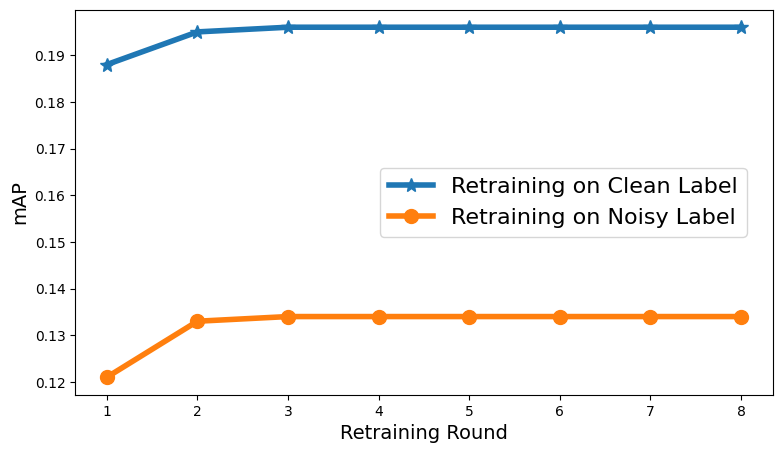

In [31]:
# Results
NN = [0.121, 0.133] + [0.134] * 6
NC = [0.117, 0.133] + [0.134] * 6
CN = [0.073, 0.06] + [0.059] * 6
CC = [0.188, 0.195] + [0.196] * 6
NR = [0.2] * 8

plt.figure(figsize=(9,5))

#plt.plot(NR, label='No Retraining(Baseline)', marker='D', markersize=8)
plt.plot(CC, label='Retraining on Clean Label', marker='*', markersize=10, linewidth=4)
plt.plot(NN, label='Retraining on Noisy Label', marker='o', markersize=10, linewidth=4)
#plt.plot(NC, label='Noised Image, Clean Label', marker='x')
#plt.plot(CN, label='Clean Image, Noised Label', marker='s')

#plt.title('mAP on Retraining Dataset Noise')
plt.xticks(ticks=range(8), labels=range(1,9))
plt.xlabel('Retraining Round', fontsize=14)
plt.ylabel('mAP', fontsize=14)
plt.legend(loc='center', bbox_to_anchor=(0.7,0.5), fontsize=16)
plt.grid(False)

plt.savefig('mAP_on_Retraining_Dataset_Noise.png')
plt.show()

## 7.2. 잡음 발생 위치에 따른 Golden model의 예측을 통한 생성 라벨의 수

In [ ]:
# 범주와 값
# Results
categories = ['No Retraining\n(Default)', 'Clean Image\nClean Label', 'Noised Image\nNoise Label', 'Noised Image\nClean Label', 'Clean Image\nNoised Label']
values = [8000, 7963, 4147, 7963, 4101]

# 막대그래프를 그리기 위한 준비
plt.figure(figsize=(10, 6))

colors = ['blue', 'orange', 'green', 'red', 'purple']

# 막대그래프 생성
bars = plt.bar(categories, values, color=colors)

for bar in bars:
    yval = bar.get_height()  # 막대의 높이(값)를 가져옴
    plt.text(bar.get_x() + bar.get_width()/2, yval/2, int(yval), ha='center', va='bottom')

# 그래프의 제목과 라벨을 설정
plt.title('Dataset Size on Noise Existence')
plt.ylabel('Dataset Size')

# 그래프를 화면에 표시
plt.savefig('Dataset_Size_on_Noise_Existence')
plt.show()